# LABORATORIO 5
### Alicia Paola Méndez Girón

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from feature_engine.imputation import(
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder
)

from feature_engine.transformation import LogTransformer


import joblib

In [101]:
import my_preprocessors as mypp

In [102]:
pd.pandas.set_option('display.max_columns', None) #habilitamos despliegue maximo de columnas

In [105]:
data = pd.read_csv('titanic.csv')
print(data.shape)


(891, 12)


In [106]:
data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [107]:
data.drop('PassengerId', axis=1, inplace=True)
data.drop('Name', axis=1, inplace=True)
data.drop('Ticket', axis=1, inplace=True)

In [108]:
data.head()

Survived  Pclass     Sex   Age  SibSp  Parch     Fare Cabin Embarked
0         0       3    male  22.0      1      0   7.2500   NaN        S
1         1       1  female  38.0      1      0  71.2833   C85        C
2         1       3  female  26.0      0      0   7.9250   NaN        S
3         1       1  female  35.0      1      0  53.1000  C123        S
4         0       3    male  35.0      0      0   8.0500   NaN        S

### Análisis de Datos para toma de decisiones en FE Pipeline

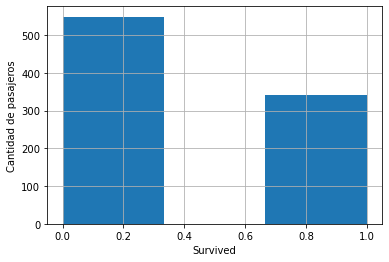

In [156]:
data['Survived'].hist(bins=3, density=False)
plt.xlabel('Survived')
plt.ylabel("Cantidad de pasajeros")
plt.show()

### Verificamos tipos de variables en x

In [109]:
data.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [110]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']
#data.dtypes

cat_vars

['Sex', 'Cabin', 'Embarked']

In [111]:
#Asegurarnos que todas quedan tipo categoría

data[cat_vars] = data[cat_vars].astype('O')
data[cat_vars].dtypes

Sex         object
Cabin       object
Embarked    object
dtype: object

In [112]:
#Variables numericas
num_vars = [var for var in data.columns if(var not in cat_vars and var != 'Survived')]

In [113]:
data[num_vars].dtypes

Pclass      int64
Age       float64
SibSp       int64
Parch       int64
Fare      float64
dtype: object

### Análisis de valores faltantes (verificar el porcentaje de pérdida y cómo impacta el target)

In [114]:
var_with_na = [var for var in data.columns if (data[var].isnull().sum() > 0)] #is null mapea True o False, y por eso se suma
var_with_na

['Age', 'Cabin', 'Embarked']

In [115]:
#proporcion de NAs en cada variable
data[var_with_na].isnull().mean().sort_values(ascending = False)

Cabin       0.771044
Age         0.198653
Embarked    0.002245
dtype: float64

In [116]:
#Funcion
def na_impact_over_target(df,Xvar, Yvar):
    df = data.copy()
    df[Xvar] = np.where(df[Xvar].isnull(), 1, 0)
    temp = df.groupby(Xvar)[Yvar].agg(['mean', 'std'])
    temp.plot(kind = "barh", y="mean", xerr="std", legend=False, title=Yvar)
    plt.show()

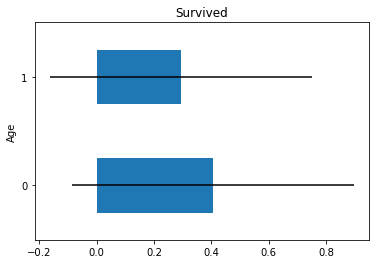

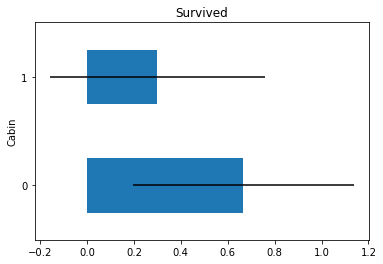

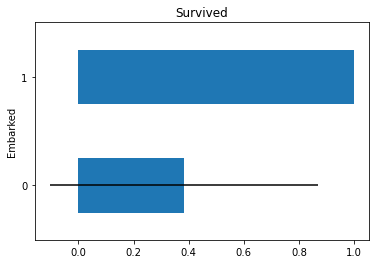

In [117]:
for var in var_with_na:
    na_impact_over_target(data, var, 'Survived')

### Análisis de variables temporales

No se cuentan con variables temporales.

## Variables discretas

In [118]:
discrete_vars = [var for var in num_vars if ((len(data[var].unique()) < 20))]
discrete_vars

['Pclass', 'SibSp', 'Parch']

In [119]:
data[discrete_vars].head()

Pclass  SibSp  Parch
0       3      1      0
1       1      1      0
2       3      0      0
3       1      1      0
4       3      0      0

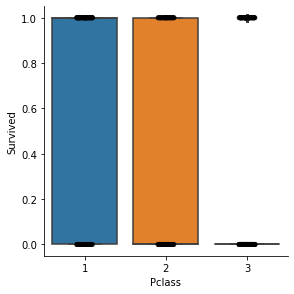

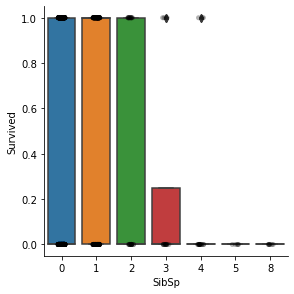

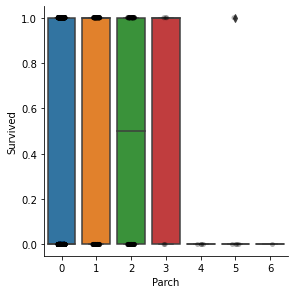

In [120]:
for var in discrete_vars:
    sns.catplot(x= var, y='Survived', data=data, kind="box", height=4)
    sns.stripplot(x= var, y='Survived', data=data, jitter=0.1, alpha=0.3, color='k')
    plt.show()

## Variables continuas

In [121]:
cont_vars = [var for var in num_vars if var not in discrete_vars ]
cont_vars

['Age', 'Fare']

In [122]:
print("Cantidad de Variables Continuas: ", len(cont_vars))

Cantidad de Variables Continuas:  2


In [123]:
data[cont_vars].head()

Age     Fare
0  22.0   7.2500
1  38.0  71.2833
2  26.0   7.9250
3  35.0  53.1000
4  35.0   8.0500

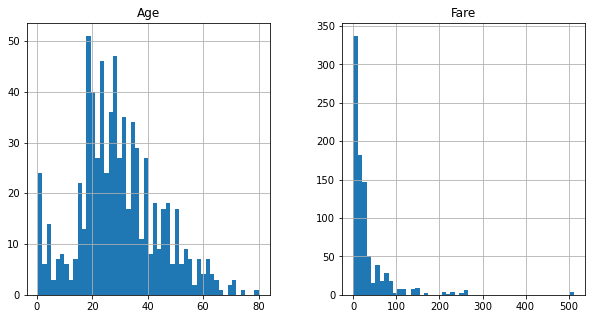

In [124]:
data[cont_vars].hist(bins=50, figsize=(10,5))
plt.show()

### transformación especial de Yeo-Johnson

In [125]:
import scipy.stats as stats

In [126]:
temp_yj = data.copy()
for var in cont_vars:
    temp_yj[var], param= stats.yeojohnson(data[var])

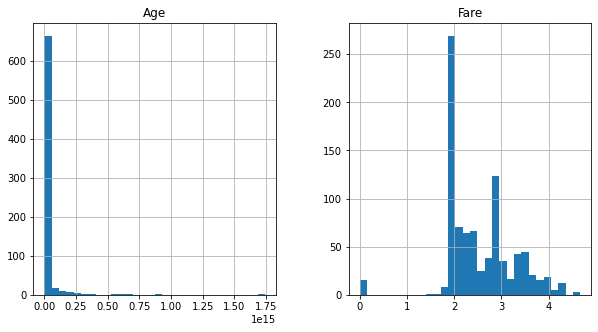

In [127]:
temp_yj[cont_vars].hist(bins=30, figsize=(10,5))
plt.show()

In [128]:
temp = data.copy()

for var in cont_vars:
    temp[var]= np.log(data[var]+1)

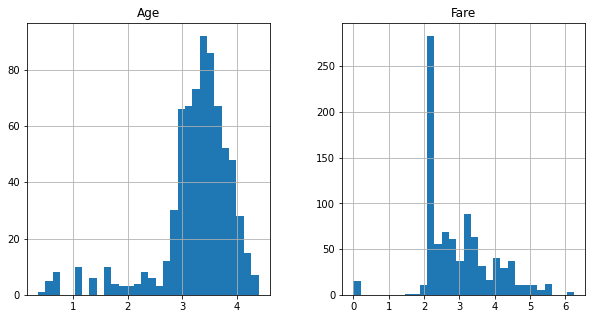

In [129]:
temp[cont_vars].hist(bins=30, figsize=(10,5))
plt.show()

Para la variable Age no haremos ninguna transformación.

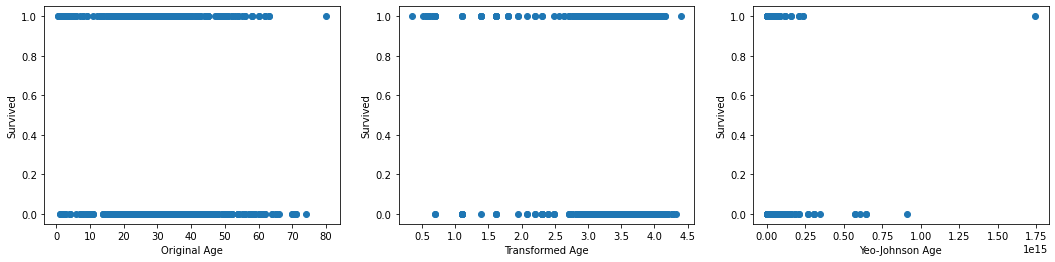

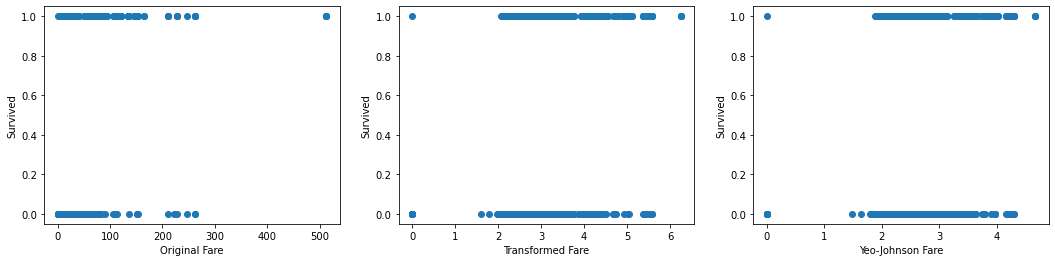

In [130]:
for var in cont_vars:
    plt.figure(figsize=(18, 4))
    
    plt.subplot(1, 3, 1)
    plt.scatter(data[var], (data['Survived']))
    plt.ylabel("Survived")
    plt.xlabel("Original " + var)
    
    plt.subplot(1, 3, 2)
    plt.scatter(temp[var], (data['Survived']))
    plt.ylabel("Survived")
    plt.xlabel("Transformed " + var)
    
    plt.subplot(1, 3, 3)
    plt.scatter(temp_yj[var], (data['Survived']))
    plt.ylabel("Survived")
    plt.xlabel("Yeo-Johnson " + var)

    plt.show()

### Variables categóricas

In [131]:
data[cat_vars].head()

Sex Cabin Embarked
0    male   NaN        S
1  female   C85        C
2  female   NaN        S
3  female  C123        S
4    male   NaN        S

<AxesSubplot:>

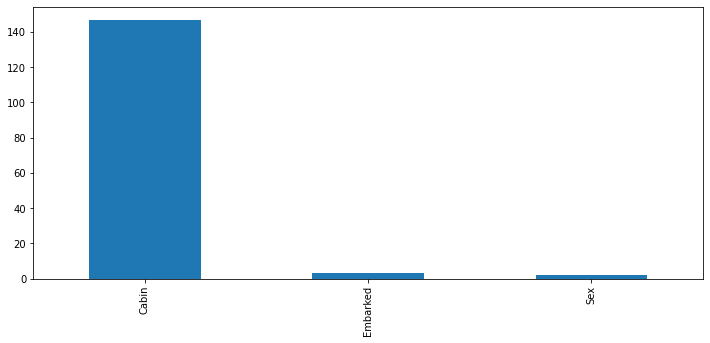

In [132]:
data[cat_vars].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

### Mapeo de variables

In [133]:
data['Sex'].unique()

array(['male', 'female'], dtype=object)

In [134]:
sex_mapping = {'male': 0, 'female':1, 'Missing':0, 'NA':0, 'NaN':0 }
sex_var = ['Sex']

In [135]:
for var in sex_var:
    data[var] = data[var].map(sex_mapping)

In [136]:
data.head()

Survived  Pclass  Sex   Age  SibSp  Parch     Fare Cabin Embarked
0         0       3    0  22.0      1      0   7.2500   NaN        S
1         1       1    1  38.0      1      0  71.2833   C85        C
2         1       3    1  26.0      0      0   7.9250   NaN        S
3         1       1    1  35.0      1      0  53.1000  C123        S
4         0       3    0  35.0      0      0   8.0500   NaN        S

In [137]:
data['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [138]:
data['Embarked'] = data['Embarked'].astype(str)
embarked_mapping = {'C':1, 'Q':2, 'S': 3, 'nan': 0}
embarked_var = ['Embarked']

In [139]:
for var in embarked_var:
    data[var] = data[var].map(embarked_mapping)

In [140]:
data.head()

Survived  Pclass  Sex   Age  SibSp  Parch     Fare Cabin  Embarked
0         0       3    0  22.0      1      0   7.2500   NaN         3
1         1       1    1  38.0      1      0  71.2833   C85         1
2         1       3    1  26.0      0      0   7.9250   NaN         3
3         1       1    1  35.0      1      0  53.1000  C123         3
4         0       3    0  35.0      0      0   8.0500   NaN         3

In [141]:
age_var = ['Age']

## Tratamiento de valores faltantes numéricos

In [142]:
for var in age_var:
    mean_val = data[var].mean()
    
    print(var, mean_val)
    
    data[var].fillna(mean_val, inplace=True)

Age 29.69911764705882


In [143]:
print("El % de valores faltantes para las variables numéricas es:")
data[var_with_na].isnull().mean()

El % de valores faltantes para las variables numéricas es:


Age         0.000000
Cabin       0.771044
Embarked    0.000000
dtype: float64

In [144]:
#Eliminando CABIN
data.drop('Cabin', axis=1, inplace=True)
data.head()

Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0         0       3    0  22.0      1      0   7.2500         3
1         1       1    1  38.0      1      0  71.2833         1
2         1       3    1  26.0      0      0   7.9250         3
3         1       1    1  35.0      1      0  53.1000         3
4         0       3    0  35.0      0      0   8.0500         3

## Feature Scaling

In [145]:
X_train, X_test, y_train, y_test = train_test_split(
                        data.drop(['Survived'], axis=1),
                        data['Survived'],
                        test_size=0.25,
                        random_state=2021)

In [146]:
X_train.shape, X_test.shape, y_train.shape

((668, 7), (223, 7), (668,))

In [154]:
scaler = MinMaxScaler()
scaler.clip = False 
scaler.fit(X_train)

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)


X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

In [155]:
X_train.head()

Pclass  Sex       Age  SibSp     Parch      Fare  Embarked
0     1.0  0.0  0.334058    0.0  0.000000  0.013761  1.000000
1     1.0  0.0  0.397922    0.0  0.000000  0.014110  0.333333
2     1.0  1.0  0.007883    0.0  0.333333  0.030726  0.333333
3     0.0  0.0  0.809731    0.0  0.000000  0.051822  1.000000
4     1.0  0.0  0.225333    0.0  0.000000  0.016908  1.000000

### Guardando data

In [156]:
#Guardamos dataset con data preparada para entrenamiento.

X_train.to_csv('C:/Users/Paola Méndez/Jupyter/Product Development/Lab_2_3_4/prep_Xtrain.csv', index=False)
X_test.to_csv('C:/Users/Paola Méndez/Jupyter/Product Development/Lab_2_3_4/prep_Xtest.csv', index=False)

y_train.to_csv('C:/Users/Paola Méndez/Jupyter/Product Development/Lab_2_3_4/prep_ytrain.csv', index=False)
y_test.to_csv('C:/Users/Paola Méndez/Jupyter/Product Development/Lab_2_3_4/prep_ytest.csv', index=False)

In [157]:
joblib.dump(scaler, 'C:/Users/Paola Méndez/Jupyter/Product Development/Lab_2_3_4/minmax_scaler.joblib')

['C:/Users/Paola Méndez/Jupyter/Product Development/Lab_2_3_4/minmax_scaler.joblib']

## Selección de variables

In [158]:
X_train = pd.read_csv('C:/Users/Paola Méndez/Jupyter/Product Development/Lab_2_3_4/prep_Xtrain.csv')
X_test = pd.read_csv('C:/Users/Paola Méndez/Jupyter/Product Development/Lab_2_3_4/prep_Xtest.csv')
X_train.head()

Pclass  Sex       Age  SibSp     Parch      Fare  Embarked
0     1.0  0.0  0.334058    0.0  0.000000  0.013761  1.000000
1     1.0  0.0  0.397922    0.0  0.000000  0.014110  0.333333
2     1.0  1.0  0.007883    0.0  0.333333  0.030726  0.333333
3     0.0  0.0  0.809731    0.0  0.000000  0.051822  1.000000
4     1.0  0.0  0.225333    0.0  0.000000  0.016908  1.000000

In [159]:
y_train = pd.read_csv('C:/Users/Paola Méndez/Jupyter/Product Development/Lab_2_3_4/prep_ytrain.csv')
y_test = pd.read_csv('C:/Users/Paola Méndez/Jupyter/Product Development/Lab_2_3_4/prep_ytest.csv')
y_train.head()

Survived
0         0
1         0
2         1
3         0
4         0

In [160]:
sel_ = SelectFromModel(Lasso(alpha=0.001, random_state=0))
sel_.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.001, random_state=0))

In [161]:
sel_.get_support().sum()

5

In [162]:
selected_features = X_train.columns[(sel_.get_support())]

In [163]:
selected_features

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Embarked'], dtype='object')

### Entrenamiento del Modelo

In [164]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [165]:
# Modelo a seleccionar
modelo_clasific = RandomForestClassifier()
modelo_clasific.fit(X_train, y_train.values.ravel())

RandomForestClassifier()

### Predicciones

In [166]:
preds_train = modelo_clasific.predict(X_train)
preds_test = modelo_clasific.predict(X_test)

Los resultados en una matriz de confusión:


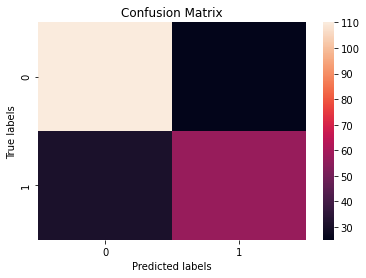

array([[110,  25],
       [ 31,  57]], dtype=int64)

In [167]:
print('Los resultados en una matriz de confusión:')

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, preds_test),  fmt='g', ax = ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix')
plt.show()

confusion_matrix(y_test, preds_test)

In [168]:
print('El accuracy del modelo es de: ',accuracy_score(y_test, preds_test))

El accuracy del modelo es de:  0.7488789237668162


In [169]:
#Resultados del Train
print("MSE de entrenamiento: {}".format(mean_squared_error((y_train), (preds_train))))
print("RMSE de entrenamiento: {}".format(mean_squared_error((y_train)
                                                            , (preds_train)
                                                           , squared=False)))
print("R2 de entrenamiento: {}".format(r2_score((y_train), (preds_train))))

MSE de entrenamiento: 0.058383233532934134
RMSE de entrenamiento: 0.24162622691449315
R2 de entrenamiento: 0.7522537943626613


In [170]:
#Resultados del test
print("MSE de entrenamiento: {}".format(mean_squared_error((y_test), (preds_test))))
print("RMSE de entrenamiento: {}".format(mean_squared_error((y_test)
                                                            , (preds_test)
                                                           , squared=False)))
print("R2 de entrenamiento: {}".format(r2_score((y_test), (preds_test))))

MSE de entrenamiento: 0.25112107623318386
RMSE de entrenamiento: 0.501119822231354
R2 de entrenamiento: -0.051178451178451434


In [171]:
joblib.dump(modelo_clasific, 'C:/Users/Paola Méndez/Jupyter/Product Development/Lab_5/random_forest.joblib')

['C:/Users/Paola Méndez/Jupyter/Product Development/Lab_5/random_forest.joblib']

# CONFIGURACIÓN PIPELINE

In [172]:
data = pd.read_csv('train.csv')

In [173]:
X_train, X_test, y_train, y_test = train_test_split(
        data.drop(['Survived', 'PassengerId','Cabin'], axis=1),
        data['Survived'],
        test_size=0.1,
        random_state=2022)

X_train.shape, X_test.shape

((801, 9), (90, 9))

In [174]:
X, y = data.drop(['Survived'], axis=1), data['Survived']

### Feature selection

In [176]:
#Variables categoricas con NA
CATEGORICAL_VARS_WITH_NA = ['Sex', 'Embarked']

CATEGORICAL_VARS_WITH_NA_FREQ = ['Sex', 'Embarked']

#Variables numéricas con NA
NUMERICAL_VARS_WITH_NA = ['Age']

#Varibles para transformación logaritmia
NUMERICALS_LOG_VARS = ["Fare"]

#Variables para hacer mapeo categorico 
BINARY_VARS =  ['Sex']
MAR_VARS = ['Embarked']

#Mapeos de variables categoricas
BINARY_MAP = {'male': 0, 'female': 1}

MAR_MAP = {'C':1, 'Q':2, 'S': 3, 'nan': 0}

#Variables seleccionadas según análisis de Lasso
FEATURES = ['Pclass', 'Sex', 'Age', 'SibSp', 'Embarked']

In [177]:
X_train = X_train[FEATURES]

In [178]:
Survived_pipeline = Pipeline([
    
    #============= IMPUTACIONES ===================#
    
      
    #1. Imputación de variables categoricas con NA basado en frequiencia.
    ('frequent_imputation', 
         CategoricalImputer(imputation_method='frequent', variables=CATEGORICAL_VARS_WITH_NA_FREQ)
    ),
    
    #2. Faltante en variables numéricas
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)),
    
    #3. Imputación de mediana para variables categoricas
    ('mean_imputation', MeanMedianImputer(
        imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA)
    ),
    
    #=============== CODIFICACION DE VARIABLES CATEGORICAS ORDINALES ==============

    ('mapper_quality', mypp.Mapper(
        variables=BINARY_VARS, mappings=BINARY_MAP)),
    
    ('mapper_exposure', mypp.Mapper(
        variables=MAR_VARS, mappings=MAR_MAP)),
     
    #=========== SCALER ==============
    ('scaler', MinMaxScaler()),
    
    #=========== ENTRENAMIENTO DEL MODELO ============
    ('Lasso', Lasso(alpha=0.01, random_state=2022)),
]) 

In [179]:
Survived_pipeline

Pipeline(steps=[('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['Sex', 'Embarked'])),
                ('missing_indicator', AddMissingIndicator(variables=['Age'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['Age'])),
                ('mapper_quality',
                 Mapper(mappings={'female': 1, 'male': 0}, variables=['Sex'])),
                ('mapper_exposure',
                 Mapper(mappings={'C': 1, 'Q': 2, 'S': 3, 'nan': 0},
                        variables=['Embarked'])),
                ('scaler', MinMaxScaler()),
                ('Lasso', Lasso(alpha=0.01, random_state=2022))])

In [180]:
Survived_pipeline.fit(X_train, y_train)

Pipeline(steps=[('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['Sex', 'Embarked'])),
                ('missing_indicator', AddMissingIndicator(variables=['Age'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['Age'])),
                ('mapper_quality',
                 Mapper(mappings={'female': 1, 'male': 0}, variables=['Sex'])),
                ('mapper_exposure',
                 Mapper(mappings={'C': 1, 'Q': 2, 'S': 3, 'nan': 0},
                        variables=['Embarked'])),
                ('scaler', MinMaxScaler()),
                ('Lasso', Lasso(alpha=0.01, random_state=2022))])

### Seleccionamos variables para predicción

In [181]:
X_test = X_test[FEATURES]

In [182]:
preds = Survived_pipeline.predict(X_test)

In [183]:
mean_squared_error(np.exp(y_test), np.exp(preds), squared=False)

0.5751796065958027

In [184]:
X_test.head()

Pclass     Sex   Age  SibSp Embarked
770       3    male  24.0      0        S
178       2    male  30.0      0        S
786       3  female  18.0      0        S
159       3    male   NaN      8        S
656       3    male   NaN      0        S

In [185]:
X_train.head()

Pclass     Sex   Age  SibSp Embarked
350       3    male  23.0      0        S
113       3  female  20.0      1        S
34        1    male  28.0      1        C
172       3  female   1.0      1        S
296       3    male  23.5      0        C

In [186]:
#Guardamos pipeline
joblib.dump(Survived_pipeline, 'C:/Users/Paola Méndez/Jupyter/Product Development/Lab_5/Survived_pipeline.pkl')

['C:/Users/Paola Méndez/Jupyter/Product Development/Lab_5/Survived_pipeline.pkl']

In [187]:
type(Survived_pipeline)

sklearn.pipeline.Pipeline

In [188]:
data = pd.read_csv('train.csv')
data.to_json('Lab_prueba.json', orient='records')